In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import json
from datetime import datetime

In [2]:
basedir = "/raid/MattC/repos/spear_thesis_analysis/"

In [3]:
# Load the JSON file
with open(f'{basedir}/curated_lineages.json', 'r') as file:
    json_data = json.load(file)

lineage_to_name = {}
# Populate the lineage_to_who_name dictionary
for entry in json_data:
    variant_type = entry.get('variantType')
    pangolin_lineages = entry.get('pango_descendants')
    name = entry.get('who_name')
    if not name:
        name = entry.get('mutation_synonyms')[0]
    classifications = entry.get('classifications')
    # Initialize the date variable
    date = datetime.fromtimestamp(0).date()
    
    # Find the WHO classification date
    for classification in classifications:
        if classification.get("author") == "WHO":
            if classification.get('dateModified'):
                date = datetime.strptime(classification.get('dateModified'),'%Y-%m-%d').date()
            break  # Assuming there is only one relevant WHO classification per entry
    # Update the lineage_to_who_name dictionary
    if pangolin_lineages and name and date:
        for pangolin_lineage in pangolin_lineages:
            if pangolin_lineage in lineage_to_name:
                # Check if the existing date is older than the new date
                if lineage_to_name[pangolin_lineage]['lineage_date'] < date:
                    lineage_to_name[pangolin_lineage] = {
                        'lineage_name': name,
                        'lineage_date': date,
                        'lineage_type': variant_type
                    }
            else:
                # Add the new entry if it doesn't exist
                lineage_to_name[pangolin_lineage] = {
                    'lineage_name': name,
                    'lineage_date': date,
                    'lineage_type': variant_type
                }
                
lineage_mapping_df = pd.DataFrame(lineage_to_name).T.reset_index().rename(columns = {"index": "pangolin_lineage"})

#use https://github.com/corneliusroemer/pango-sequences/blob/main/data/pango-consensus-sequences_summary.json for mapping to nextstrain clades
# Load the JSON file
with open(f'{basedir}/pango-consensus-sequences_summary.json', 'r') as file:
    json_data = json.load(file)

#the nextstrain clades in this file are not accurate for the latest clades so we overwrite them for these. 
#lineage JN.1 was designated as clade 24A and JN.1.11.1 as 24B
lineage_to_nextstrain = {}
for entry, data in json_data.items():
    if data["parent"] == "JN.1" or data["parent"].startswith("JN.1.") or entry == "JN.1":
        lineage_to_nextstrain[entry] = "24A"
    elif data["parent"] == "JN.1.11.1" or data["parent"].startswith("JN.1.11.1.") or entry == "JN.1.11.1":
        lineage_to_nextstrain[entry] = "24B"
    elif data["parent"].startswith("KP."):
        lineage_to_nextstrain[entry] = "24B"
    elif data["parent"].startswith("LB."):
        lineage_to_nextstrain[entry] = "24A"
    else:
        lineage_to_nextstrain[entry] = data["nextstrainClade"]
    
lineage_to_nextstrain_date = {}
# Populate the lineage_to_who_name dictionary
for entry, data in json_data.items():
    if data['designationDate'] != "":
        lineage_to_nextstrain_date[entry] = datetime.strptime(data["designationDate"], '%Y-%m-%d').date()

In [5]:
lineages_mutations = pd.read_csv(f"{basedir}/representative_lineages_genbank/spear_representative_lineages_genbank/spear_annotation_summary.tsv", sep = "\t")
lineages_mutations["respos"] = lineages_mutations.residues.str.extract(r"^[A-Z]([\d\.]+)[A-Za-z]+").astype("float")
lineages_mutations["respos"] = lineages_mutations["respos"].fillna(-1).astype("int")
lineages_mutations['altres'] = lineages_mutations["residues"].str.extract(r'[A-Z\*]-*[0-9\.]+-*([a-zA-Z\*\?]+)')
pangolin_report = pd.read_csv(f"{basedir}/representative_lineages_genbank/spear_representative_lineages_genbank/lineage_report.csv")
lineages_mutations = lineages_mutations.merge(pangolin_report, how = "left", left_on = "sample_id", right_on = "taxon")
#get spike rbd mutations only
spike_df = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.consequence_type != "synonymous_variant") & (lineages_mutations.residues.isna() == False) & (lineages_mutations.respos >= 331) & (lineages_mutations.respos <= 531)]

# group by sample_id and agg the mutation profiles
spike_profiles = spike_df.groupby('sample_id')['residues'].apply(lambda x: ','.join(sorted(set(x)))).reset_index().rename(columns = {'residues':'spike_rbd_profile'})
spike_profiles["spike_rbd_profile_id"] = spike_profiles.groupby('spike_rbd_profile').transform("ngroup")

# count spike profiles
shared_profiles = spike_profiles['spike_rbd_profile_id'].value_counts().reset_index()
shared_profiles.columns = ['spike_rbd_profile_id', 'sample_count']

# merge shared profile counts with the original profiles df.
spike_profiles = spike_profiles.merge(shared_profiles, on='spike_rbd_profile_id', how='left')

lineages_score_report = pd.read_csv(f"{basedir}/representative_lineages_genbank/spear_representative_lineages_genbank/spear_score_summary.tsv", sep = "\t")
lineages_score_report = lineages_score_report.merge(pangolin_report, how = "left", left_on = "sample_id", right_on = "taxon")
lineages_score_report = lineages_score_report.merge(lineage_mapping_df, left_on = "lineage", right_on = "pangolin_lineage", how = "left")
lineages_score_report = lineages_score_report.merge(spike_profiles, on = "sample_id", how = "left", indicator = True)
lineages_score_report["nextstrainClade"] = lineages_score_report["lineage"].map(lineage_to_nextstrain)
lineages_score_report["designationDate"] = lineages_score_report["lineage"].map(lineage_to_nextstrain_date)
lineages_score_report_date = lineages_score_report.loc[~lineages_score_report.designationDate.isna()]#.nextstrainClade.value_counts()
lineages_score_report_date['designationDate'] = pd.to_datetime(lineages_score_report_date['designationDate']) #convert to a pandas datetime format

/tmp/ipykernel_1609979/914313030.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineages_score_report_date['designationDate'] = pd.to_datetime(lineages_score_report_date['designationDate']) #convert to a pandas datetime format


In [6]:
lineage_unique_aa_mutations = lineages_mutations[lineages_mutations.columns[list(range(8,28)) + [29]]].drop_duplicates()
lineage_unique_nt_mutations = lineages_mutations[lineages_mutations.columns[list(range(1,28)) + [29]]].drop_duplicates()

In [7]:
print(f"""
{lineages_score_report.sample_id.nunique()} lineages were analysed, resulting in a total of {len(lineage_unique_nt_mutations)} nucleotide mutations 
across all analysed lineages, resulting in {len(lineage_unique_aa_mutations)} amino acids (including synonymous 
amino acid mutations.

Designation dates are available for {len(lineages_score_report_date)} of the analysed lineages, allowing for 
temporal analysis of functional and structural features of the lineages.

Many functional scores of SARS-CoV-2 lineages focus upon residues within the RBD 
of the Spike protein. A total of {spike_profiles.spike_rbd_profile_id.nunique()} different Spike RBD profiles were seen across
the analysed lineages. The most common spike RBD profile is {spike_profiles.sort_values("sample_count", ascending = False).spike_rbd_profile.values[0]}
""")


2940 lineages were analysed, resulting in a total of 6935 nucleotide mutations 
across all analysed lineages, resulting in 6480 amino acids (including synonymous 
amino acid mutations.

Designation dates are available for 2324 of the analysed lineages, allowing for 
temporal analysis of functional and structural features of the lineages.

Many functional scores of SARS-CoV-2 lineages focus upon residues within the RBD 
of the Spike protein. A total of 356 different Spike RBD profiles were seen across
the analysed lineages. The most common spike RBD profile is L452R,T478K



## Monoclonal Antibody Escape Heatmaps for lineages

In [38]:
lineage_clade_mapping = {
    "B.1.1.7": "B.1.1.7 (Alpha/20I)",
    "B.1.617.2": "B.1.617.2 (Delta/21A)",
    "BA.1": "BA.1 (Omicron/21K)",
    "BA.2": "BA.2 (Omicron/21L)",
    "BA.5": "BA.5 (Omicron/22B)",
    "BQ.1": "BQ.1 (Omicron/22E)",
    "XBB.1.5": "XBB.1.5 (Omicron/23A)",
    "EG.5": "EG.5 (Omicron/23F)",
    "HK.3": "HK.3 (Omicron/23H)",
    "BA.2.86": "BA.2.86 (Omicron/23I)",
    "JN.1": "JN.1 (Omicron/24A)",
    "KP.3.1": "KP.3.1 (Omicron/24C)",
    
}

In [9]:
#use ay.102 as it classifies as b.1.617.2 and ba.1.18 as it classifies as ba.1
#ba.2.16 as it classifies as ba.2 and has the signature mutations
lineages = {"B.1.1.7" : "Alpha", "B.1.617.2" : "Delta", "BA.1": "BA.1" , "BA.2" : "BA.2", "BA.5":"BA.5", "BQ.1": "BQ.1", "XBB.1.5": "XBB.1.5", "EG.5" : "EG.5", "HK.3" : "HK.3", "BA.2.86": "BA.2.86", "JN.1": "JN.1", "KP.3.1": "KP.3.1"}

In [57]:
mab_escape_class1_vocs = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.sample_id.isin(lineages.keys())) & (lineages_mutations.respos != -1) & (lineages_mutations.mAb_escape_class_1.isna() == False)]
mab_escape_class1_vocs_pivot = mab_escape_class1_vocs.pivot(columns = "respos", index = "sample_id", values = "mAb_escape_class_1")
mab_escape_class1_vocs_pivot_label = mab_escape_class1_vocs.pivot(columns = "respos", index = "sample_id", values = "altres")
#reorder to correct timeline
mab_escape_class1_vocs_pivot = mab_escape_class1_vocs_pivot.reindex(lineages.keys())
mab_escape_class1_vocs_pivot_label = mab_escape_class1_vocs_pivot_label.reindex(lineages.keys())
#add voc and clade to lineage index
mab_escape_class1_vocs_pivot.index = mab_escape_class1_vocs_pivot.index.map(lineage_clade_mapping)

mab_escape_class2_vocs = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.sample_id.isin(lineages.keys())) & (lineages_mutations.respos != -1) & (lineages_mutations.mAb_escape_class_2.isna() == False)]
mab_escape_class2_vocs_pivot = mab_escape_class2_vocs.pivot(columns = "respos", index = "sample_id", values = "mAb_escape_class_2")
mab_escape_class2_vocs_pivot_label = mab_escape_class2_vocs.pivot(columns = "respos", index = "sample_id", values = "altres")
#reorder to correct timeline 
mab_escape_class2_vocs_pivot = mab_escape_class2_vocs_pivot.reindex(lineages.keys())
mab_escape_class2_vocs_pivot_label = mab_escape_class2_vocs_pivot_label.reindex(lineages.keys())
mab_escape_class2_vocs_pivot.index = mab_escape_class2_vocs_pivot.index.map(lineage_clade_mapping)

mab_escape_class3_vocs = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.sample_id.isin(lineages.keys())) & (lineages_mutations.respos != -1) & (lineages_mutations.mAb_escape_class_3.isna() == False)]
mab_escape_class3_vocs_pivot = mab_escape_class3_vocs.pivot(columns = "respos", index = "sample_id", values = "mAb_escape_class_3")
mab_escape_class3_vocs_pivot_label = mab_escape_class3_vocs.pivot(columns = "respos", index = "sample_id", values = "altres")
#reorder to correct timeline 
mab_escape_class3_vocs_pivot = mab_escape_class3_vocs_pivot.reindex(lineages.keys())
mab_escape_class3_vocs_pivot_label = mab_escape_class3_vocs_pivot_label.reindex(lineages.keys())
mab_escape_class3_vocs_pivot.index = mab_escape_class3_vocs_pivot.index.map(lineage_clade_mapping)

mab_escape_class4_vocs = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.sample_id.isin(lineages.keys())) & (lineages_mutations.respos != -1) & (lineages_mutations.mAb_escape_class_4.isna() == False)]
mab_escape_class4_vocs_pivot = mab_escape_class4_vocs.pivot(columns = "respos", index = "sample_id", values = "mAb_escape_class_4")
mab_escape_class4_vocs_pivot_label = mab_escape_class4_vocs.pivot(columns = "respos", index = "sample_id", values = "altres")
#reorder to correct timeline 
mab_escape_class4_vocs_pivot = mab_escape_class4_vocs_pivot.reindex(lineages.keys())
mab_escape_class4_vocs_pivot_label = mab_escape_class4_vocs_pivot_label.reindex(lineages.keys())
mab_escape_class4_vocs_pivot.index = mab_escape_class4_vocs_pivot.index.map(lineage_clade_mapping)

vds_vocs = lineages_mutations.loc[(lineages_mutations.description == "surface glycoprotein") & (lineages_mutations.sample_id.isin(lineages.keys())) & (lineages_mutations.respos != -1) & (lineages_mutations.VDS.isna() == False) & (lineages_mutations.respos >= 331) & (lineages_mutations.respos <= 531)]
vds_vocs_pivot = vds_vocs.pivot(columns = "respos", index = "sample_id", values = "VDS")
vds_vocs_pivot_label = vds_vocs.pivot(columns = "respos", index = "sample_id", values = "altres")
#reorder to correct timeline 
vds_vocs_pivot = vds_vocs_pivot.loc[lineages.keys()]
vds_vocs_pivot_label = vds_vocs_pivot_label.loc[lineages.keys()]
vds_vocs_pivot.index = vds_vocs_pivot.index.map(lineage_clade_mapping)

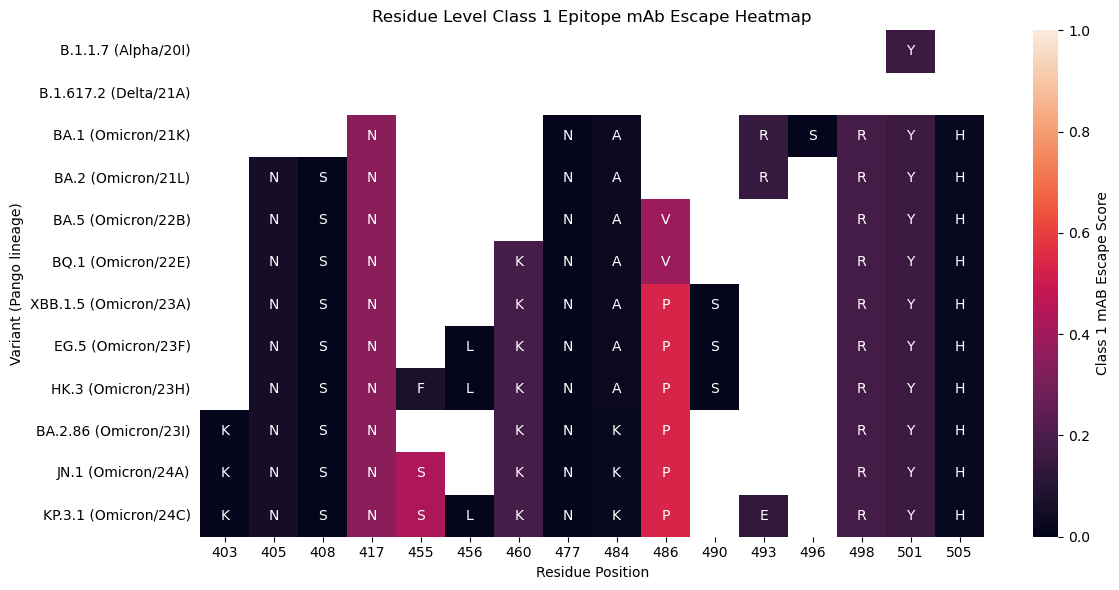

In [58]:
fig, ax = plt.subplots(figsize = (12,6))
g= sns.heatmap(mab_escape_class1_vocs_pivot, annot = mab_escape_class1_vocs_pivot_label, fmt="", vmin = 0, vmax= 1, ax = ax, cbar = True, cbar_kws = {"label": "Class 1 mAB Escape Score"})
ax.tick_params(left=False)
plt.title('Residue Level Class 1 Epitope mAb Escape Heatmap')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango lineage)')
plt.tight_layout()
plt.savefig(f"{basedir}/figures/score_heatmaps/class_1_mab_heatmap.svg")
plt.savefig(f"{basedir}/figures/score_heatmaps/class_1_mab_heatmap.png", dpi = 600)
plt.show()

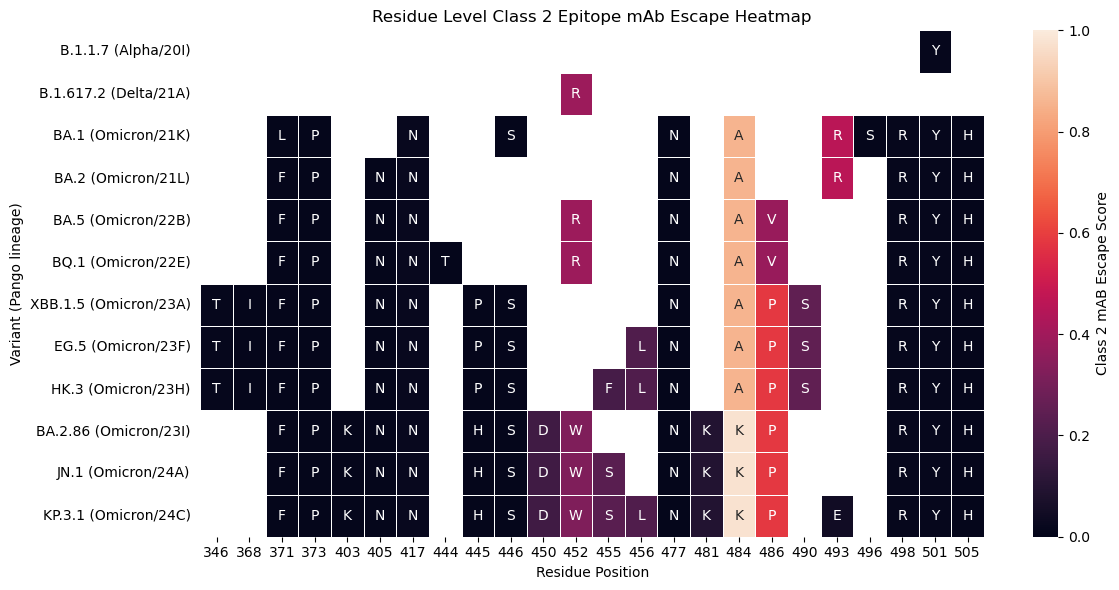

In [59]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(mab_escape_class2_vocs_pivot, annot = mab_escape_class2_vocs_pivot_label, fmt="",linewidth=.5, vmin = 0, vmax= 1, ax = ax, cbar = True, cbar_kws = {"label": "Class 2 mAB Escape Score"})
ax.tick_params(left=False)
plt.title('Residue Level Class 2 Epitope mAb Escape Heatmap')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango lineage)')
plt.tight_layout()
plt.savefig(f"{basedir}/figures/score_heatmaps/class_2_mab_heatmap.svg")
plt.savefig(f"{basedir}/figures/score_heatmaps/class_2_mab_heatmap.png", dpi = 600)
plt.show()

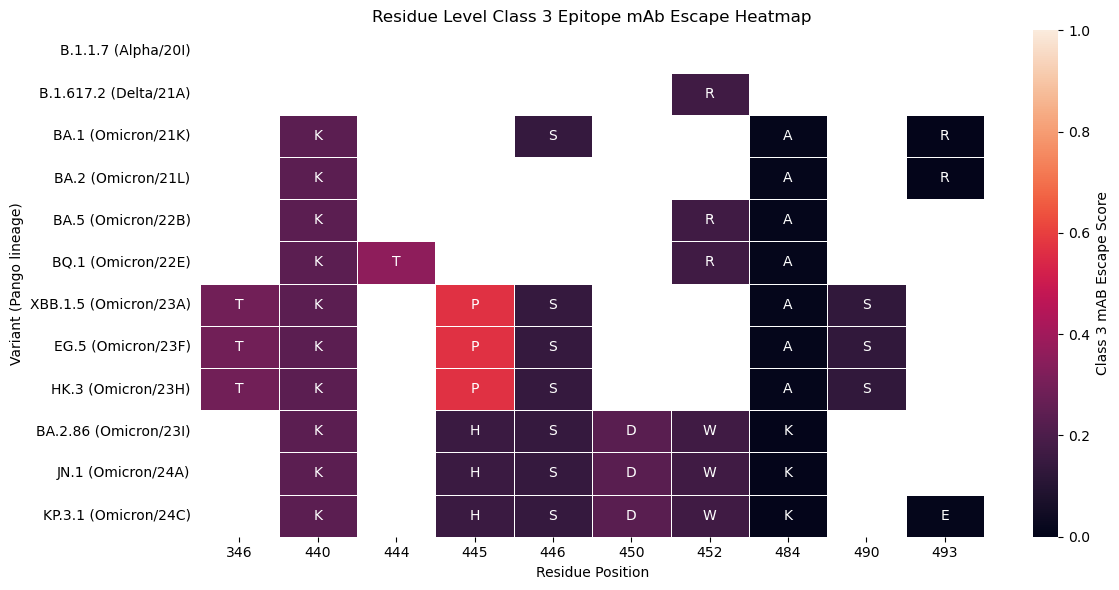

In [60]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(mab_escape_class3_vocs_pivot,annot = mab_escape_class3_vocs_pivot_label, fmt="", vmin = 0, vmax= 1, linewidth=.5, ax = ax, cbar = True , cbar_kws = {"label": "Class 3 mAB Escape Score"})
ax.tick_params(left=False)
plt.title('Residue Level Class 3 Epitope mAb Escape Heatmap')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango lineage)')
plt.tight_layout()
plt.savefig(f"{basedir}/figures/score_heatmaps/class_3_mab_heatmap.svg")
plt.savefig(f"{basedir}/figures/score_heatmaps/class_3_mab_heatmap.png", dpi = 600)
plt.show()

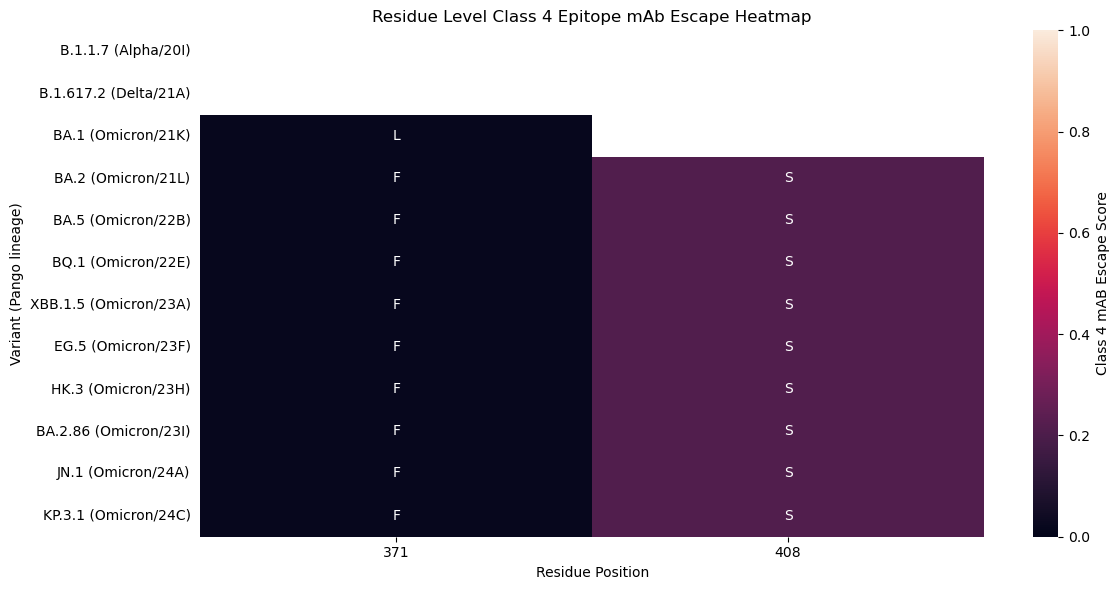

In [61]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(mab_escape_class4_vocs_pivot,annot = mab_escape_class4_vocs_pivot_label, fmt="", vmin = 0, vmax= 1, ax = ax, cbar = True, cbar_kws = {"label": "Class 4 mAB Escape Score"})
ax.tick_params(left=False)
plt.title('Residue Level Class 4 Epitope mAb Escape Heatmap')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango lineage)')
plt.tight_layout()
plt.savefig(f"{basedir}/figures/score_heatmaps/class_4_mab_heatmap.svg")
plt.savefig(f"{basedir}/figures/score_heatmaps/class_4_mab_heatmap.png", dpi = 600)
plt.show()

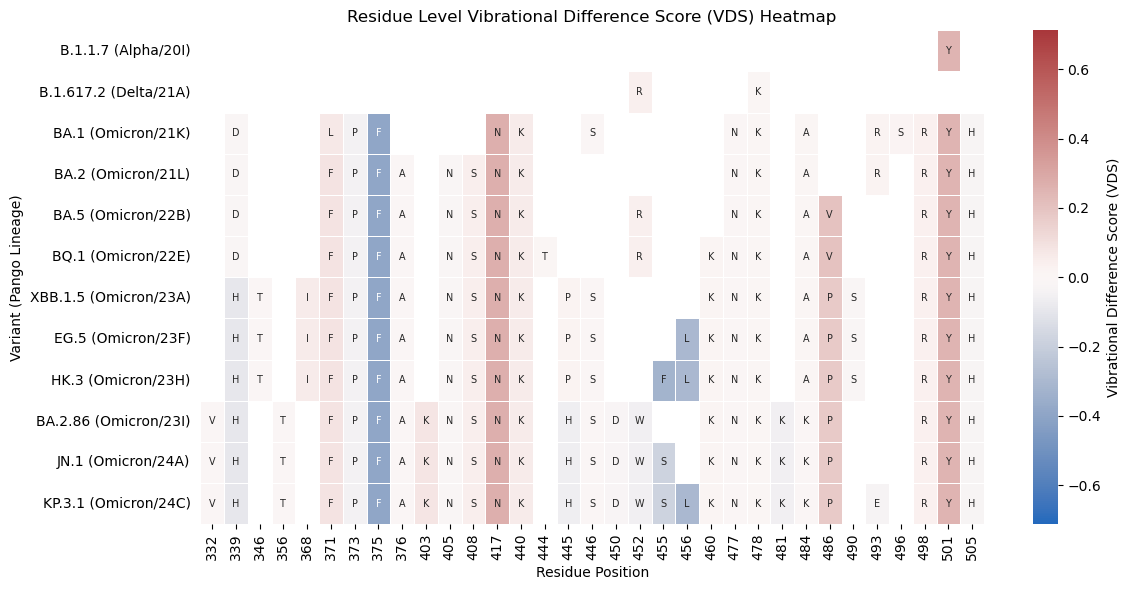

In [62]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(vds_vocs_pivot, vmax = 0.712636025 , vmin = -0.712636025, cmap = "vlag", linewidth=.5, yticklabels=True, annot= vds_vocs_pivot_label, fmt = "", annot_kws = {"fontsize": "x-small", "va": "center"}, ax = ax, cbar = True, cbar_kws={'label': 'Vibrational Difference Score (VDS)'})
ax.tick_params(left=False)
plt.title('Residue Level Vibrational Difference Score (VDS) Heatmap')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango Lineage)')
plt.tight_layout()
plt.savefig(f"{basedir}/figures/score_heatmaps/vds_heatmap.svg")
plt.savefig(f"{basedir}/figures/score_heatmaps/vds_heatmap.png", dpi = 600)
plt.show()

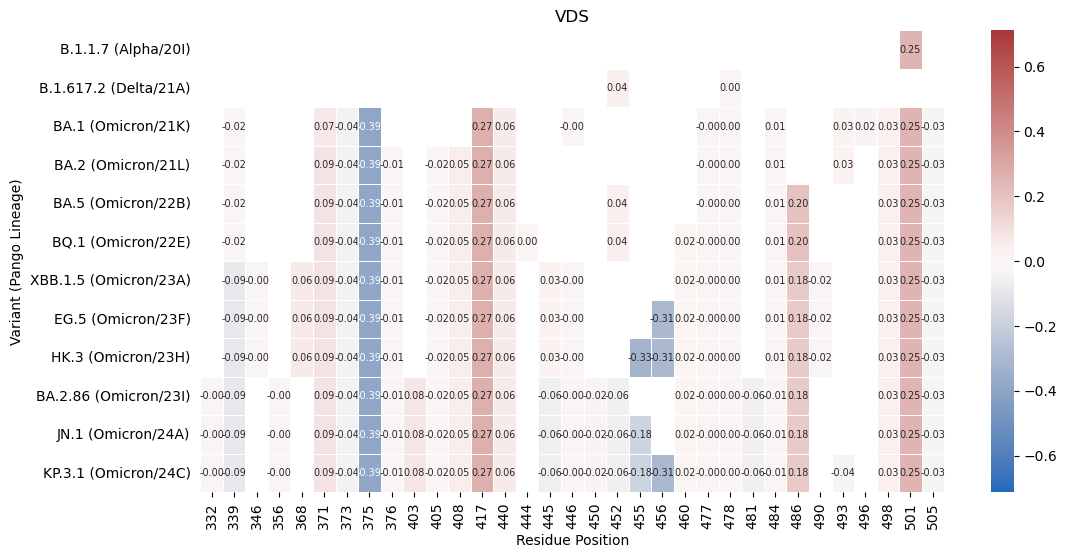

In [51]:
#for socre ref only 
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(vds_vocs_pivot, vmax = 0.712636025 , vmin = -0.712636025, cmap = "vlag", linewidth=.5, yticklabels=True, annot= True, fmt = ".2f", annot_kws = {"fontsize": "x-small", "va": "center"}, ax = ax )
ax.tick_params(left=False)
plt.title('VDS')
ax.set_xlabel('Residue Position')
ax.set_ylabel('Variant (Pango Lineage)')
plt.show()

## ACE2 Investigations



In [333]:
##ACE2 WUHAN

samples_to_compare = ["BA.1.18", "BA.2", "BA.4", "BA.5"] # use ba.1.18 as classsified as ba.1 by pangolin

ace2_wuhan_bar = lineages_mutations.loc[(lineages_mutations.sample_id.isin(samples_to_compare)) & (lineages_mutations.bloom_ACE2_wuhan.isna() == False)][["lineage", "residues", "respos", "bloom_ACE2_wuhan"]]
# Get the number of unique lineages
num_unique_lineages = ace2_wuhan_bar.lineage.nunique()
residue_counts = ace2_wuhan_bar['residues'].value_counts()
shared_mutations = ace2_wuhan_bar.loc[ace2_wuhan_bar['residues'].isin(residue_counts[residue_counts == num_unique_lineages].index), ["residues", "respos", "bloom_ACE2_wuhan"]].drop_duplicates()
shared_mutations["lineage"] = "shared"

ace2_wuhan_bar_unique = ace2_wuhan_bar.loc[ace2_wuhan_bar.residues.isin(shared_mutations.residues.unique()) == False]

ace2_wuhan_combined = pd.concat([shared_mutations, ace2_wuhan_bar_unique])


# Create the barplot

fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")
sns.barplot(data=ace2_wuhan_combined, x="lineage", y="bloom_ACE2_wuhan", hue="residues", legend = None)

## Add grid
hue_values = ace2_wuhan_bar["residues"].tolist()
threshold = 0.4
for container, number in zip(ax.containers, ace2_wuhan_bar.residues):
    yval = container.datavalues[0]
    if abs(yval) > threshold:
    #print([number, number])
        ax.bar_label(container, labels= [number]  * len(container), rotation=90, padding = 3)
ax.set_ylim((-2, 2))
# Show plot
plt.show()

#ACE2 BA2

samples_to_compare = ["BA.4", "BA.5"] # use ba.1.18 as classsified as ba.1 by pangolin

ace2_wuhan_bar = lineages_mutations.loc[(lineages_mutations.sample_id.isin(samples_to_compare)) & (lineages_mutations.bloom_ACE2_wuhan.isna() == False)][["lineage", "residues", "respos", "bloom_ACE2_BA2"]]
# Get the number of unique lineages
num_unique_lineages = ace2_wuhan_bar.lineage.nunique()
residue_counts = ace2_wuhan_bar['residues'].value_counts()
shared_mutations = ace2_wuhan_bar.loc[ace2_wuhan_bar['residues'].isin(residue_counts[residue_counts == num_unique_lineages].index), ["residues", "respos", "bloom_ACE2_BA2"]].drop_duplicates()
shared_mutations["lineage"] = "shared"

ace2_wuhan_bar_unique = ace2_wuhan_bar.loc[ace2_wuhan_bar.residues.isin(shared_mutations.residues.unique()) == False]

ace2_wuhan_combined = pd.concat([shared_mutations, ace2_wuhan_bar_unique])


# Create the barplot

fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")
sns.barplot(data=ace2_wuhan_combined, x="lineage", y="bloom_ACE2_BA2", hue="residues", legend = None)

## Add grid
hue_values = ace2_wuhan_bar["residues"].tolist()
threshold = 0
for container, number in zip(ax.containers, ace2_wuhan_bar.residues):
    yval = container.datavalues[0]
    if abs(yval) > threshold:
    #print([number, number])
        ax.bar_label(container, labels= [number]  * len(container), rotation=90, padding = 3)
ax.set_ylim((-2, 2))
# Show plot
plt.show()

2307    JN.1.11.1
Name: sample_id, dtype: object

#### Cut ACE2 Text

SPEAR also tracks ACE2 binding affinity changes for mutations in samples according to three baselines: Wuhan-Hu-1/wildtype, BA.1 and BA.2. DISCUSS HERE THE REASON FOR THE IMPLEMENTATIO NOF THE BA.1 AND BA.2 BASELINED VALUES, AND WHY BACK CALCULATION OF THESE IS NOT APPROPRIATE.

When evaluating the trends in pre-Omicron and early Omicron clades, a clear trend can be seen, with an increase in mean ACE2 binding affinity seen with the onset of Alpha VOC, followed by a return to close to wildtype levels with the occurrence of the Delta VOC and a decrease in binding affinity compared to wildtype for the earliest Omicron VOC samples. THIS IS AN OBSERVATION THAT IS SUPPROTED BY KNnfekfnef.